# Exploratory Data Analysis (EDA) of SWE-Bench Verified Annotation Data

To determine which instances of SWE-Bench Verified are to be moved into the train- and which into the test-split and to develop the methodology for doing so, we will make use of the SWE-Bench Verified annotation data [provided by OpenAI.](https://openai.com/index/introducing-swe-bench-verified/)

## Get annotation data for SWE-Bench Verified samples

In [1]:
from typing import Tuple

from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
annotation_data = pd.read_csv('../swe-bench-annotation-results/samples_with_3_annotations_public.csv')
ensembled_annotation_data = pd.read_csv('../swe-bench-annotation-results/ensembled_annotations_public.csv')

In [4]:
annotation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5097 entries, 0 to 5096
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   instance_id                 5097 non-null   object 
 1   user_id                     5097 non-null   int64  
 2   difficulty                  5096 non-null   object 
 3   difficulty_notes            5077 non-null   object 
 4   underspecified              5093 non-null   float64
 5   underspecified_notes        5096 non-null   object 
 6   false_negative              5092 non-null   float64
 7   false_negative_notes        5095 non-null   object 
 8   other_major_issues          5068 non-null   float64
 9   other_notes                 328 non-null    object 
 10  annotator_confidence        5097 non-null   int64  
 11  claimed_at                  5097 non-null   object 
 12  updated_at                  5097 non-null   object 
 13  submitted_at                5097 

In [5]:
ensembled_annotation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   instance_id                             1699 non-null   object 
 1   underspecified                          1699 non-null   float64
 2   underspecified_notes                    1699 non-null   object 
 3   false_negative                          1699 non-null   float64
 4   false_negative_notes                    1699 non-null   object 
 5   other_major_issues                      1699 non-null   float64
 6   other_notes                             203 non-null    object 
 7   difficulty                              1699 non-null   object 
 8   underspecified_decided_by               1699 non-null   int64  
 9   false_negative_decided_by               1699 non-null   int64  
 10  other_major_issues_decided_by           1699 non-null   int6

The ensembled annotation data file contains the annotations aggregate to an `instance_id` level with respect to the 1699 instance ids from SWE-Bench that they investigated. The data are aggregated by taking the maximum value, according to their blogpost. Let's quickly check this qualitatively.

In [6]:
ensembled_annotation_data[['instance_id','underspecified','false_negative', 'difficulty','other_major_issues']]

,instance_id,underspecified,false_negative,difficulty,other_major_issues
0,astropy__astropy-11693,1.0,3.0,15 min - 1 hour,0.0
1,astropy__astropy-12544,0.0,3.0,1-4 hours,0.0
2,astropy__astropy-12825,1.0,2.0,1-4 hours,0.0
3,astropy__astropy-12842,1.0,2.0,1-4 hours,0.0
4,astropy__astropy-12880,1.0,3.0,<15 min fix,0.0
...,...,...,...,...,...
1694,sympy__sympy-24539,0.0,1.0,<15 min fix,0.0
1695,sympy__sympy-24562,0.0,0.0,<15 min fix,0.0
1696,sympy__sympy-24661,0.0,0.0,15 min - 1 hour,0.0
1697,sympy__sympy-24723,1.0,0.0,<15 min fix,0.0


In [7]:
annotation_data[annotation_data['instance_id'] == 'astropy__astropy-12891'][['instance_id','underspecified','false_negative', 'difficulty','other_major_issues']]

,instance_id,underspecified,false_negative,difficulty,other_major_issues
15,astropy__astropy-12891,2.0,3.0,15 min - 1 hour,0.0
16,astropy__astropy-12891,1.0,2.0,1-4 hours,0.0
17,astropy__astropy-12891,0.0,0.0,1-4 hours,0.0


For the samples we checked, this seems to hold up. We will this continue by just looking at the aggregated dataset.

In [8]:
del annotation_data

In [9]:
ensembled_annotation_data = ensembled_annotation_data[ensembled_annotation_data['filter_out'] == False]

In [10]:
ensembled_annotation_data

,instance_id,underspecified,underspecified_notes,false_negative,false_negative_notes,other_major_issues,other_notes,difficulty,underspecified_decided_by,false_negative_decided_by,other_major_issues_decided_by,difficulty_decided_by,difficulty_ensemble_decision_procedure,filter_out
6,astropy__astropy-12907,1.0,"The issue description is clear, explaining tha...",0.0,The goal of the test patch is to evaluate nest...,0.0,NaN,15 min - 1 hour,75,75,75,"[75, 28]",majority,False
9,astropy__astropy-13033,1.0,The issue's concern is well understood. The va...,1.0,The error message is raised is particular to t...,0.0,NaN,15 min - 1 hour,61,61,13,"[13, 17]",majority,False
15,astropy__astropy-13236,1.0,1. It is clearly suggested that automatic conv...,0.0,1. Issue description wants the agent to remove...,0.0,NaN,15 min - 1 hour,71,71,71,[71],median,False
18,astropy__astropy-13398,0.0,Issue description is well specified. It inform...,0.0,The tests are well scoped and cover all possib...,0.0,NaN,1-4 hours,12,12,12,"[12, 62]",majority,False
20,astropy__astropy-13453,0.0,The issue description is very clear and well-o...,0.0,The `test_write_table_formatted_columns` funct...,0.0,NaN,15 min - 1 hour,67,67,67,"[61, 28]",majority,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,sympy__sympy-24443,1.0,The `_check_homomorphism` function is broken f...,0.0,The test patch tests the code raising error in...,0.0,NaN,15 min - 1 hour,28,28,28,"[28, 9, 12]",majority,False
1694,sympy__sympy-24539,0.0,The issue is crystal clear in the ticket. It s...,1.0,The tests specifically check whether the `as_e...,0.0,NaN,<15 min fix,7,43,7,"[7, 44, 43]",majority,False
1695,sympy__sympy-24562,0.0,The issue raises a bug where the output of `Ra...,0.0,"The tests check that the value of `Rational(p,...",0.0,NaN,<15 min fix,65,65,65,"[13, 7]",majority,False
1696,sympy__sympy-24661,0.0,The ticket is very clear. The issue is that th...,0.0,The tests are testing all the relational possi...,0.0,NaN,15 min - 1 hour,7,7,7,"[7, 10]",majority,False


We note that of the samples that 539 samples remain. That means there are still 39 more than ended up in the final SWE-Bench. The authors state that they attempt to maximize the amount of difficult samples present and then randomly sample the rest. Thus we will need to use external `instance_id` from the actual dataset to get the annotation data for the dataset.

In [11]:
swe_verified_tasks = open('../conf/swe_verified_tasks.txt', mode='r').read().splitlines()

In [12]:
ensembled_annotation_data = ensembled_annotation_data[ensembled_annotation_data['instance_id'].isin(swe_verified_tasks)]

In [13]:
ensembled_annotation_data[['instance_id','underspecified','false_negative', 'difficulty','other_major_issues']]

,instance_id,underspecified,false_negative,difficulty,other_major_issues
6,astropy__astropy-12907,1.0,0.0,15 min - 1 hour,0.0
9,astropy__astropy-13033,1.0,1.0,15 min - 1 hour,0.0
15,astropy__astropy-13236,1.0,0.0,15 min - 1 hour,0.0
18,astropy__astropy-13398,0.0,0.0,1-4 hours,0.0
20,astropy__astropy-13453,0.0,0.0,15 min - 1 hour,0.0
...,...,...,...,...,...
1688,sympy__sympy-24213,1.0,0.0,15 min - 1 hour,0.0
1692,sympy__sympy-24443,1.0,0.0,15 min - 1 hour,0.0
1694,sympy__sympy-24539,0.0,1.0,<15 min fix,0.0
1695,sympy__sympy-24562,0.0,0.0,<15 min fix,0.0


## Explore annotation data for SWE-Bench Verified samples

## Collect resolution metadata

We want to know which samples were solved by how many approaches and by which, we can take this into account when deciding how we construct the train-test splits.

In [23]:
path_to_swe_bench_verified_experiments = '../overall-swe-bench-leaderboard-data/evaluation/verified'
swe_bench_verified_resolution_data = []

In [24]:
for instance in swe_verified_tasks:
    swe_bench_verified_resolution_data.append({'instance_id': instance, 'was_resolved': False, 'times_solved': 0, 'solved_by': [], 'unsolved_by': []})

In [25]:
swe_bench_verified_resolution_data = pd.DataFrame(swe_bench_verified_resolution_data)

In [30]:
for dirpath, dirnames, filenames in os.walk(path_to_swe_bench_verified_experiments):
    if 'results' in dirpath:
        # We are in the deepest subdirectory for this approach, the results are located here
        approach_slug = dirpath.split('/')[-2]
        
        with open(os.path.join(dirpath, 'results.json'), 'r') as f:
            results = json.loads(f.read())
            resolved_instances = results['resolved']
            swe_bench_verified_resolution_data.loc[swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'was_resolved'] = True
            swe_bench_verified_resolution_data.loc[swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'times_solved'] += 1
            swe_bench_verified_resolution_data.loc[swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'solved_by'].apply(lambda x: x.append(approach_slug))
            swe_bench_verified_resolution_data.loc[~swe_bench_verified_resolution_data['instance_id'].isin(resolved_instances), 'unsolved_by'].apply(lambda x: x.append(approach_slug))

## Explore results and develop dataset splitting procedure

In [31]:
swe_bench_verified_resolution_data = pd.DataFrame(swe_bench_verified_resolution_data)

In [32]:
swe_bench_verified_resolution_data.was_resolved.value_counts()

was_resolved
True     390
False    110
Name: count, dtype: int64

In [33]:
swe_bench_verified_resolution_data.times_solved.value_counts()

times_solved
0     110
1      31
2      28
4      25
3      18
21     16
7      15
27     15
14     14
15     14
5      13
10     13
17     12
8      12
18     12
19     12
6      12
12     11
13     11
26     11
23     10
30      9
28      9
31      9
22      8
11      8
20      7
29      7
16      7
25      7
9       6
24      6
32      2
Name: count, dtype: int64

In [34]:
swe_bench_verified_resolution_data[swe_bench_verified_resolution_data['times_solved'] == 1]

,instance_id,was_resolved,times_solved,solved_by,unsolved_by
2,astropy__astropy-13236,True,1,[20240824_gru],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
11,astropy__astropy-14369,True,1,[20241029_OpenHands-CodeAct-2.1-sonnet-20241022],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
14,astropy__astropy-14598,True,1,[20241029_OpenHands-CodeAct-2.1-sonnet-20241022],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
45,django__django-11299,True,1,[20241025_composio_swekit],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
77,django__django-12273,True,1,[20241025_composio_swekit],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
89,django__django-12774,True,1,[20240824_gru],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
98,django__django-13112,True,1,[20241022_tools_claude-3-5-sonnet-updated],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
112,django__django-13406,True,1,[20241029_OpenHands-CodeAct-2.1-sonnet-20241022],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
175,django__django-15037,True,1,[20241022_tools_claude-3-5-haiku],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."
202,django__django-15695,True,1,[20241023_emergent],"[20231010_rag_claude2, 20231010_rag_gpt35, 202..."


In [35]:
swe_bench_verified = pd.merge(ensembled_annotation_data, swe_bench_verified_resolution_data, on='instance_id', how='inner')

# Remove broken repositories
While experimenting with the setup and evaluation we realized (and validated with the authors of ACR) that the environment setup of the `astropy` repository is broken. Upon further investigation we realized that the setup for `pydata/xarray` is also broken. We also noticed errors in the parsing of the test output of `pylint`. We have thus decided to pivot our study towards a feasibility study and will remove these repositories from the dataset.

In [37]:
swe_bench_verified = pd.read_json('../data/swe_bench_verified_resolution_data.json')

### What is the difficulty of the samples we remove wrt the rest of the dataset?

Are we skewing our difficulty distribution in one way or the other by removing these samples?

In [38]:
swe_bench_verified[(swe_bench_verified['instance_id'].str.contains('xarray') | swe_bench_verified['instance_id'].str.contains('astropy') | swe_bench_verified['instance_id'].str.contains('pylint'))].empiric_difficulty.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: empiric_difficulty, dtype: float64

In [ ]:
swe_bench_verified[~(swe_bench_verified['instance_id'].str.contains('xarray') | swe_bench_verified['instance_id'].str.contains('astropy') | swe_bench_verified['instance_id'].str.contains('pylint'))].empiric_difficulty.describe()

count    446.000000
mean       0.702399
std        0.279464
min        0.110000
25%        0.470000
50%        0.780000
75%        0.970000
max        1.000000
Name: empiric_difficulty, dtype: float64

In terms of empiric difficulty, we are making our dataset easier. The samples of the problematic repositories have a median empiric difficulty of 0.86, compared to the median empiric difficulty of 0.78 of the remaining dataset. This is important to keep in mind when drawing conclusions about the potential of our methodology.

In [ ]:
swe_bench_verified[(swe_bench_verified['instance_id'].str.contains('xarray') | swe_bench_verified['instance_id'].str.contains('astropy') | swe_bench_verified['instance_id'].str.contains('pylint'))].difficulty.value_counts(normalize=True)

difficulty
15 min - 1 hour    0.648148
<15 min fix        0.222222
1-4 hours          0.111111
>4 hours           0.018519
Name: proportion, dtype: float64

In [ ]:
swe_bench_verified[~(swe_bench_verified['instance_id'].str.contains('xarray') | swe_bench_verified['instance_id'].str.contains('astropy') | swe_bench_verified['instance_id'].str.contains('pylint'))].difficulty.value_counts(normalize=True)

difficulty
15 min - 1 hour    0.506726
<15 min fix        0.408072
1-4 hours          0.080717
>4 hours           0.004484
Name: proportion, dtype: float64

In [ ]:
swe_bench_verified = swe_bench_verified[~(swe_bench_verified['instance_id'].str.contains('xarray') | swe_bench_verified['instance_id'].str.contains('astropy') | swe_bench_verified['instance_id'].str.contains('pylint'))]

### Are `false_negative` samples empirically more difficult?

In [40]:
swe_bench_verified['solved_by'].apply(lambda x: len(x) == 0).value_counts()

solved_by
False    347
True      99
Name: count, dtype: int64

In [37]:
390/500

0.78

A surprising by, product here, is that ~78% of samples in SWE-Bench Verified were solved by at least one system. However, the top resolution rate as of 5.11.24 is OpenHands+CodeAct with 53%. So there is something of a 25% gain just lying around.

In [41]:
swe_bench_verified[swe_bench_verified['false_negative'] == 1]['solved_by'].apply(lambda x: len(x) > 0).value_counts()

solved_by
True     121
False     54
Name: count, dtype: int64

In [42]:
54/121

0.4462809917355372

In [43]:
swe_bench_verified[swe_bench_verified['false_negative'] == 0]['solved_by'].apply(lambda x: len(x) > 0).value_counts()

solved_by
True     226
False     45
Name: count, dtype: int64

In [44]:
45/226

0.19911504424778761

It does seem like samples that have well-specified tests that cover every possible solution are ~25% points more likely to be correctly resolved. To ensure this isnt confounded by difficulty, let's also correct for this.

In [45]:
for difficulty_level in swe_bench_verified.difficulty.unique():
    value_counts_for_well_specified_tests = swe_bench_verified[(swe_bench_verified['false_negative'] == 0) & (swe_bench_verified['difficulty'] == difficulty_level)]['solved_by'].apply(lambda x: len(x) > 0).value_counts()
    
    value_counts_for_ambiguous_tests = swe_bench_verified[(swe_bench_verified['false_negative'] == 1) & (swe_bench_verified['difficulty'] == difficulty_level)]['solved_by'].apply(lambda x: len(x) > 0).value_counts()
    
    ratio_well_defined = 'N/A' if len(value_counts_for_well_specified_tests) == 0 else round(value_counts_for_well_specified_tests.iloc[1]/value_counts_for_well_specified_tests.iloc[0], 2)
    ratio_ambiguous = 'N/A' if len(value_counts_for_ambiguous_tests) == 0 else round(value_counts_for_ambiguous_tests.iloc[1]/value_counts_for_ambiguous_tests.iloc[0], 2)
    
    print(f'For difficulty level "{difficulty_level} and {len(swe_bench_verified[swe_bench_verified["difficulty"] == difficulty_level])} samples within this category:"\n'
          f'\tfor well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: {ratio_well_defined}"\n'
          f'\tfor ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: {ratio_ambiguous}"\n\n')

For difficulty level "<15 min fix and 182 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 0.09"
	for ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: 0.14"


For difficulty level "1-4 hours and 36 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 0.29"
	for ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: 0.42"


For difficulty level "15 min - 1 hour and 226 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 0.26"
	for ambiguous tests (false_negative == 1) the ratio of unresolved to resolved samples is: 0.41"


For difficulty level ">4 hours and 2 samples within this category:"
	for well-specified tests (false_negative == 0) the ratio of unresolved to resolved samples is: 1.0"
	for amb

Let's see if the effect of the test ambiguity on sample resolution rate is statistically significant.

In [46]:
chi2_contingency(np.array([[226, 45], [121, 54]]))

Chi2ContingencyResult(statistic=np.float64(11.694642140567893), pvalue=np.float64(0.0006268032380362891), dof=1, expected_freq=array([[210.84529148,  60.15470852],
       [136.15470852,  38.84529148]]))

Thus our findings are significant at alpha=0.01 and we will include this feature in our considerations for re-shuffling data.

### Does `difficulty` in samples impact resolution rate?

In [47]:
f_observed = []
for difficulty_level in swe_bench_verified.difficulty.unique():
    value_counts = swe_bench_verified[swe_bench_verified['difficulty'] == difficulty_level]['solved_by'].apply(lambda x: len(x) > 0).value_counts()
    f_observed.append([value_counts.iloc[0], value_counts.iloc[1]])
    
f_observed = np.array(f_observed)
chi2_contingency(f_observed)

Chi2ContingencyResult(statistic=np.float64(18.515431103941218), pvalue=np.float64(0.0003442937766232185), dof=3, expected_freq=array([[148.13004484,  33.86995516],
       [ 29.30044843,   6.69955157],
       [183.94170404,  42.05829596],
       [  1.62780269,   0.37219731]]))

This is also statistically significant at alpha=0.01.

### Are `underspecified` samples empirically more difficult?

In [48]:
f_observed = []
for difficulty_level in swe_bench_verified.underspecified.unique():
    value_counts = swe_bench_verified[swe_bench_verified['underspecified'] == difficulty_level]['solved_by'].apply(lambda x: len(x) > 0).value_counts()
    f_observed.append([value_counts.iloc[0], value_counts.iloc[1]])
    
f_observed = np.array(f_observed)
chi2_contingency(f_observed)

Chi2ContingencyResult(statistic=np.float64(0.23294976522886401), pvalue=np.float64(0.6293451957153475), dof=1, expected_freq=array([[163.38565022,  46.61434978],
       [183.61434978,  52.38565022]]))

In [46]:
swe_bench_verified[swe_bench_verified['underspecified'] == 1]['solved_by'].apply(lambda x: len(x) > 0).value_counts()

solved_by
True     201
False     61
Name: count, dtype: int64

In [47]:
61/201

0.3034825870646766

In [48]:
swe_bench_verified[swe_bench_verified['underspecified'] == 0]['solved_by'].apply(lambda x: len(x) > 0).value_counts()

solved_by
True     189
False     49
Name: count, dtype: int64

In [49]:
49/189

0.25925925925925924

### Computing `empiric_difficulty` 

We define empiric difficulty as the inverse ratio of agents that have solved a sample over the amount of agents competing on SWE-Bench. This way samples that were solved by all agents have an `empiric_difficulty` of 0 and unsolved samples have an `empiric_difficulty` of 1.

In [49]:
number_of_competing_agents = len(swe_bench_verified.loc[0, 'solved_by'] + swe_bench_verified.loc[0, 'unsolved_by'])

In [50]:
swe_bench_verified['empiric_difficulty'] = round(1-(swe_bench_verified['times_solved']/number_of_competing_agents),2) # Round to be able to compare (otherwise trailing float differences make it hard)

How do `empiric_difficulty` and `difficulty` co-occur?

In [55]:
mapping = {
    '<15 min fix': 0,
    '15 min - 1 hour': 1,
    '1-4 hours': 2,
    '>4 hours': 3
}
swe_bench_verified['difficulty_encoded'] = swe_bench_verified['difficulty'].map(mapping)

In [56]:
swe_bench_verified['empiric_difficulty'].corr(swe_bench_verified['difficulty_encoded'])

np.float64(0.42313578235272714)

We note a moderate correlation between the difficulty rating provided by OpenAI via annotation and the empiric difficulty of the samples based on the resolution rate of systems competing on SWE-Bench Verified.

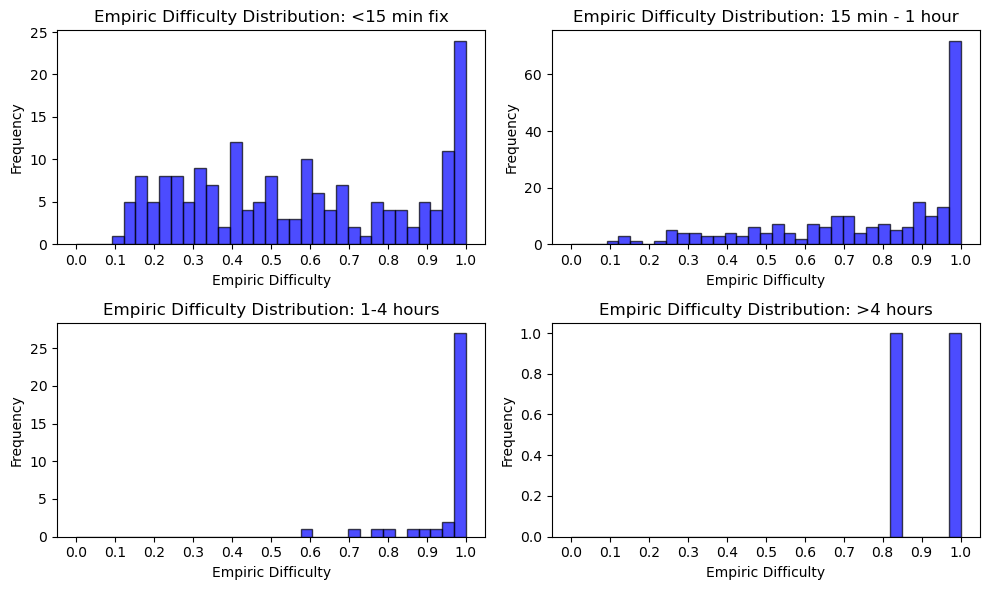

In [57]:
# Mapping the difficulty levels to numerics
if 'difficulty_encoded' not in swe_bench_verified.columns:
    swe_bench_verified['difficulty_encoded'] = swe_bench_verified['difficulty'].map(mapping)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Titles for the subplots
titles = ['<15 min fix', '15 min - 1 hour', '1-4 hours', '>4 hours']

# Loop through each difficulty level and plot histogram
for idx, ax in enumerate(axes.flat):
    difficulty_level = titles[idx]
    data = swe_bench_verified[swe_bench_verified['difficulty_encoded'] == idx]['empiric_difficulty']
    ax.hist(data, bins=len(swe_bench_verified.empiric_difficulty.unique()), alpha=0.7, color='blue', edgecolor='black', range=[0,1])
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_title(f'Empiric Difficulty Distribution: {difficulty_level}')
    ax.set_xlabel('Empiric Difficulty')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../report_resources/empiric_difficulty_distribution.pdf')

We also visually observe this, for lower difficulty categories, the distribution is more evenly spread across empiric difficulty levels and for the two most difficulty categories, we exclusively observe unsolved samples or samples that were only solved by few systems.

## Splitting the dataset
For splitting the dataset, we will consider the statistically significantly related features `difficulty` and `false_positive`. Based on these we will perform stratified splitting. We will then use `empiric_difficulty` to validate an even spread of difficulty across the two splits and make adjustments if needed.

In [60]:
swe_bench_verified['difficulty_slugged'] = swe_bench_verified['difficulty'].apply(lambda x: '_'.join(x.split(' ')))

If we include `empiric_difficulty` here already, our classes become too small.

In [61]:
swe_bench_verified['stratify_column'] = swe_bench_verified['difficulty_slugged'].astype(str) + '_' + swe_bench_verified['false_negative'].astype(str)

In terms of the annotated, subjective difficulty, we observe a similar picture. The removed samples are skewed towards increased difficulty, with 14% points more samples in the 15 min - 1 hours category, for example.

In [62]:
train_df, test_df = train_test_split(swe_bench_verified, test_size=0.1, stratify=swe_bench_verified['stratify_column'], random_state=42)

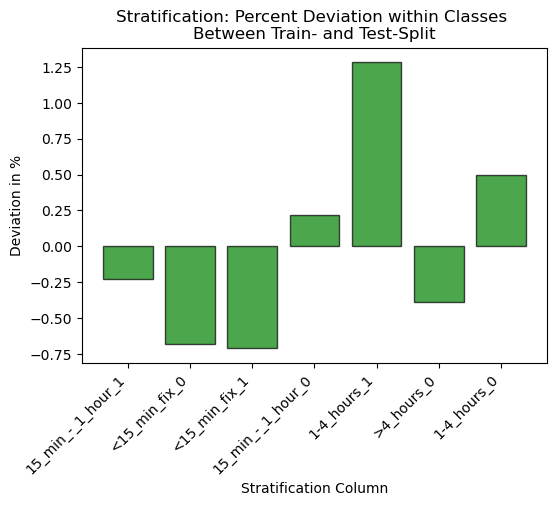

In [63]:
def build_stratification_class_deviation_plot(train_df: pd.DataFrame, test_df: pd.DataFrame):    
    fig, ax = plt.subplots(figsize=(6, 5))  
    
    data = train_df.stratify_column.value_counts(normalize=True).sub(test_df.stratify_column.value_counts(normalize=True), fill_value=0) * 100
    
    colors = ['red' if abs(value) > 2.01 else 'green' for value in data]
    
    ax.bar(train_df.stratify_column.unique(), data, alpha=0.7, color=colors, edgecolor='black')
    ax.set_title('Stratification: Percent Deviation within Classes \nBetween Train- and Test-Split')
    ax.set_xlabel('Stratification Column')
    ax.set_ylabel('Deviation in %')
    plt.gcf().subplots_adjust(bottom=0.25)
    plt.xticks(rotation=45, ha='right')
    
    return plt
plt = build_stratification_class_deviation_plot(train_df, test_df)
plt.savefig('../report_resources/train_test_difficulty_deviation.pdf')

The stratification worked quite well, the deviations are below 1.25% with respect to the stratification classes defined by `stratification_column`. Furthermore, we note that the negative deviations indicate an over representation in the test-split, since we compute the deviation through train - test. We note that the simplest class < 15min quick fix is more prevalent in the train split. As for the hardest classes. For 1-4 hours, we have an over representation of the harder case with underspecified tests. For the easier case, we have a slight over representation in train split. For tasks that were estimated to take the longest by annotators, we have a slight under representation in the test-split. 

Overall, there is some indication that the difficulty levels across train-test splits are well balance, with the test split seeming to be slightly more difficult. Before we decide whether further adjustments are needed, let's also consult the empiric difficulty distribution.

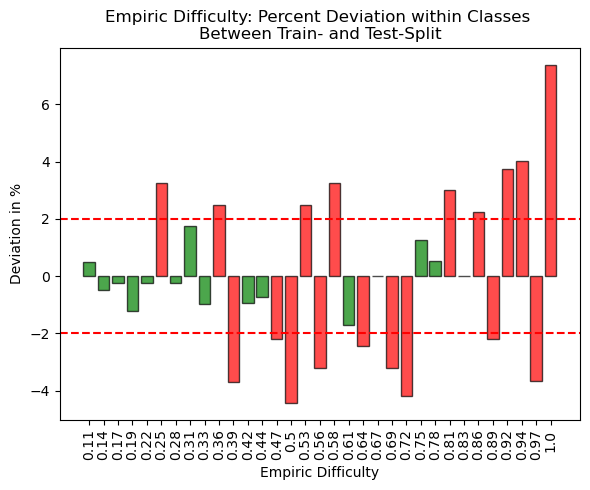

In [64]:
def build_empiric_difficulty_deviation_plot(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Plots the percent deviation of empirical difficulty percentages between train and test datasets.

    This function calculates the percent deviation of empirical difficulties between the
    train and test datasets, and visualizes it as a bar plot. The empirical difficulties are 
    grouped, and the deviation is color-coded: red for significant deviations and green for 
    non-significant deviations. The threshold for a significant deviation is set to 2.01%,
    we use this instead of 2% to account for floating point inaccuracies.

    Args:
        train_df (pd.DataFrame): The training dataset containing an 'empiric_difficulty' column.
        test_df (pd.DataFrame): The test dataset containing an 'empiric_difficulty' column.

    Returns:
        plt: The matplotlib.pyplot object containing the bar plot.
    """
    # Removed the incorrect tuple unpacking of plt.figure and set up ax correctly 
    _, ax = plt.subplots(figsize=(6, 5))  
    
    # Loop through each difficulty level and plot histogram
    data = train_df.empiric_difficulty.value_counts(normalize=True).sub(test_df.empiric_difficulty.value_counts(normalize=True), fill_value=0) * 100
    data = data.sort_index()
    empiric_difficulty_labels = [str(label) for label in data.index]
    
    colors = ['red' if abs(value) > 2.01 else 'green' for value in data]
    
    ax.bar(empiric_difficulty_labels, data, alpha=0.7, color=colors, edgecolor='black')
    ax.set_title('Empiric Difficulty: Percent Deviation within Classes \nBetween Train- and Test-Split')
    ax.set_xlabel('Empiric Difficulty')
    ax.set_ylabel('Deviation in %')
    
    plt.axhline(y=2, color='r', linestyle='--')
    plt.axhline(y=-2, color='r', linestyle='--')
    
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt

plt = build_empiric_difficulty_deviation_plot(train_df, test_df)
plt.savefig('../report_resources/train_test_empiric_difficulty_deviation.pdf')

This plot concerns our hunch above, that the test-split is on the more difficult side when compared to the train-split. We have a 4-6% over representation of the empirically most difficult samples (unsolved, or solved by a single system). However, on other difficulty levels the deviations are more well balanced. In line with other agentic works we settle for this slightly harder test-split, to really test the system capabilities and do not re-shuffle samples to ensure that the difficulties of the splits are as close as possible. At the same time however, we also dont further inflate the difficulty of our test-split.

In [65]:
test_df.empiric_difficulty.value_counts()

empiric_difficulty
1.00    7
0.97    4
0.50    3
0.72    3
0.89    3
0.42    2
0.39    2
0.64    2
0.61    2
0.47    2
0.56    2
0.69    2
0.17    1
0.33    1
0.94    1
0.78    1
0.83    1
0.19    1
0.22    1
0.67    1
0.14    1
0.44    1
0.28    1
Name: count, dtype: int64

In [49]:
test_df[['instance_id', 'times_solved','solved_by','difficulty','empiric_difficulty']].sort_values(by='empiric_difficulty', ascending=False)

,instance_id,times_solved,solved_by,difficulty,empiric_difficulty
431,sympy__sympy-13091,0,[],15 min - 1 hour,1.00
138,django__django-14011,0,[],1-4 hours,1.00
50,django__django-11477,0,[],15 min - 1 hour,1.00
27,django__django-10999,0,[],<15 min fix,1.00
332,pytest-dev__pytest-10356,0,[],1-4 hours,1.00
194,django__django-15503,0,[],1-4 hours,1.00
412,sphinx-doc__sphinx-9229,0,[],1-4 hours,1.00
246,django__django-16938,1,[20241023_emergent],15 min - 1 hour,0.97
254,matplotlib__matplotlib-14623,1,[20240920_solver],15 min - 1 hour,0.97
287,mwaskom__seaborn-3069,1,[20240924_solver],15 min - 1 hour,0.97


In [66]:
train_df.shape

(401, 22)

In [67]:
test_df.shape

(45, 22)

In [68]:
with open('../conf/swe_verified_test_tasks.txt', 'r') as f:
    test_tasks = f.readlines()
    
# Check that each item in test_tasks matches an instance_id in test_df
test_tasks = [task.strip() for task in test_tasks]  # Remove any whitespace/newlines
test_ids_in_df = set(test_df['instance_id'].tolist())
test_ids_in_file = set(test_tasks)

# Check if all tasks in the file are in the DataFrame
missing_from_df = test_ids_in_file - test_ids_in_df
if missing_from_df:
    print(f"Warning: {len(missing_from_df)} tasks in test_tasks.txt are not in test_df:")
    print(list(missing_from_df)[:5], "..." if len(missing_from_df) > 5 else "")

# Check if all instances in the DataFrame are in the file
missing_from_file = test_ids_in_df - test_ids_in_file
if missing_from_file:
    print(f"Warning: {len(missing_from_file)} instances in test_df are not in test_tasks.txt:")
    print(list(missing_from_file)[:5], "..." if len(missing_from_file) > 5 else "")

# Print summary
if not missing_from_df and not missing_from_file:
    print(f"✓ All {len(test_ids_in_df)} test instances match between test_df and test_tasks.txt")
else:
    print(f"Total instances in test_df: {len(test_ids_in_df)}")
    print(f"Total tasks in test_tasks.txt: {len(test_ids_in_file)}")
    

✓ All 45 test instances match between test_df and test_tasks.txt


In [52]:
train_df.to_json('../data/train.json', indent=4, orient='records', force_ascii=False)
test_df.to_json('../data/test.json', indent=4, orient='records', force_ascii=False)

In [53]:
with open('../conf/swe_verified_train_tasks.txt', 'w+') as f:
    for instance in train_df.loc[:, "instance_id"]:
        f.write(f"{instance}\n")
        
with open('../conf/swe_verified_test_tasks.txt', 'w+') as f:
    for instance in test_df.loc[:, "instance_id"]:
        f.write(f"{instance}\n")

In [54]:
swe_bench_verified.to_json('../data/swe_bench_verified_resolution_data.json', indent=4, orient='records', force_ascii=False)

In [9]:
import pandas as pd
import seaborn as sns

In [6]:
train_df = pd.read_json('../data/train.json', orient='records')

In [22]:
train_repos = train_df['instance_id'].str.split('__', expand=True)[0].value_counts()
labels_train = train_repos.index.tolist()
sizes_train = train_repos.values.tolist()
palette = sns.color_palette('pastel', n_colors=len(labels_train))
color_map = {}
for idx, label in enumerate(labels_train):
    color_map[label] = palette[idx]

In [16]:
color_map

{'django': (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 'sympy': (1.0, 0.7058823529411765, 0.5098039215686274),
 'sphinx-doc': (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 'scikit-learn': (1.0, 0.6235294117647059, 0.6078431372549019),
 'matplotlib': (0.8156862745098039, 0.7333333333333333, 1.0),
 'pytest-dev': (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 'psf': (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 'mwaskom': (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 'pallets': (1.0, 0.996078431372549, 0.6392156862745098)}

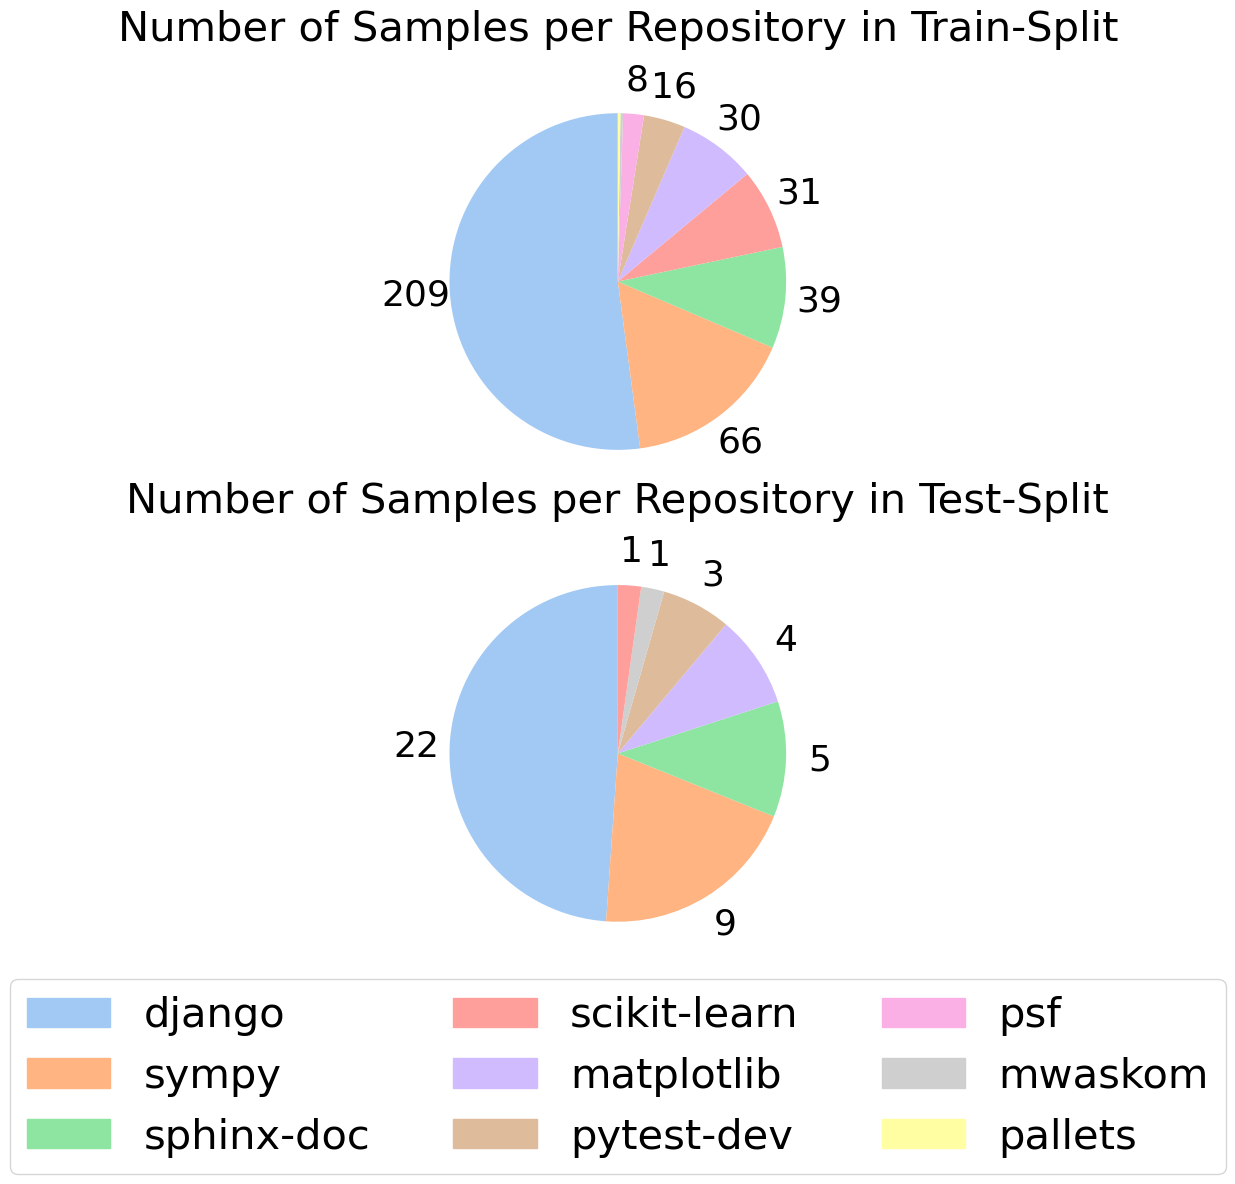

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get repository counts for train and test sets
train_repos = train_df['instance_id'].str.split('__', expand=True)[0].value_counts()
test_repos = test_df['instance_id'].str.split('__', expand=True)[0].value_counts()

# Extract labels and sizes for both charts
labels1 = train_repos.index.tolist()
sizes1 = train_repos.values.tolist()

labels2 = test_repos.index.tolist()
sizes2 = test_repos.values.tolist()

# Choose a Seaborn palette
palette = sns.color_palette('pastel', n_colors=max(len(labels1), len(labels2)))

# Map each repository in the train set to a specific color
color_map = {}
for idx, label in enumerate(labels1):
    color_map[label] = palette[idx]

# Prepare colors for each slice in the train pie chart, in train order
colors1 = [color_map[label] for label in labels1]

# Prepare colors for each slice in the test pie chart, matching the train color if it exists
colors2 = [color_map.get(label, 'grey') for label in labels2]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Plot the first pie chart
wedges1, _ = ax1.pie(sizes1, colors=colors1, startangle=90)
ax1.axis('equal')
ax1.set_title('Number of Samples per Repository in Train-Split', fontsize=30, pad=40)

# Add annotations to the first pie chart
for i, wedge in enumerate(wedges1):
    if sizes1[i] > 1:
        ang = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = wedge.r * 1.2 * np.cos(np.deg2rad(ang))
        y = wedge.r * 1.2 * np.sin(np.deg2rad(ang))
        ax1.text(x, y, str(sizes1[i]), ha='center', va='center', fontsize=26)

# Plot the second pie chart
wedges2, _ = ax2.pie(sizes2, colors=colors2, startangle=90)
ax2.axis('equal')
ax2.set_title('Number of Samples per Repository in Test-Split', fontsize=30, pad=40)

# Add annotations to the second pie chart
for i, wedge in enumerate(wedges2):
    if sizes2[i] > 0:
        ang = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = wedge.r * 1.2 * np.cos(np.deg2rad(ang))
        y = wedge.r * 1.2 * np.sin(np.deg2rad(ang))
        ax2.text(x, y, str(sizes2[i]), ha='center', va='center', fontsize=26)

# Create a legend with the train labels in the correct order
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(labels1))]
fig.legend(
    handles, labels1, loc='lower center',
    ncol=(len(labels1) + 1) // 3, bbox_to_anchor=(0.5, -0.05), fontsize=30
)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('../report_resources/repository_distribution_across_splits.pdf', bbox_inches='tight')
plt.show()

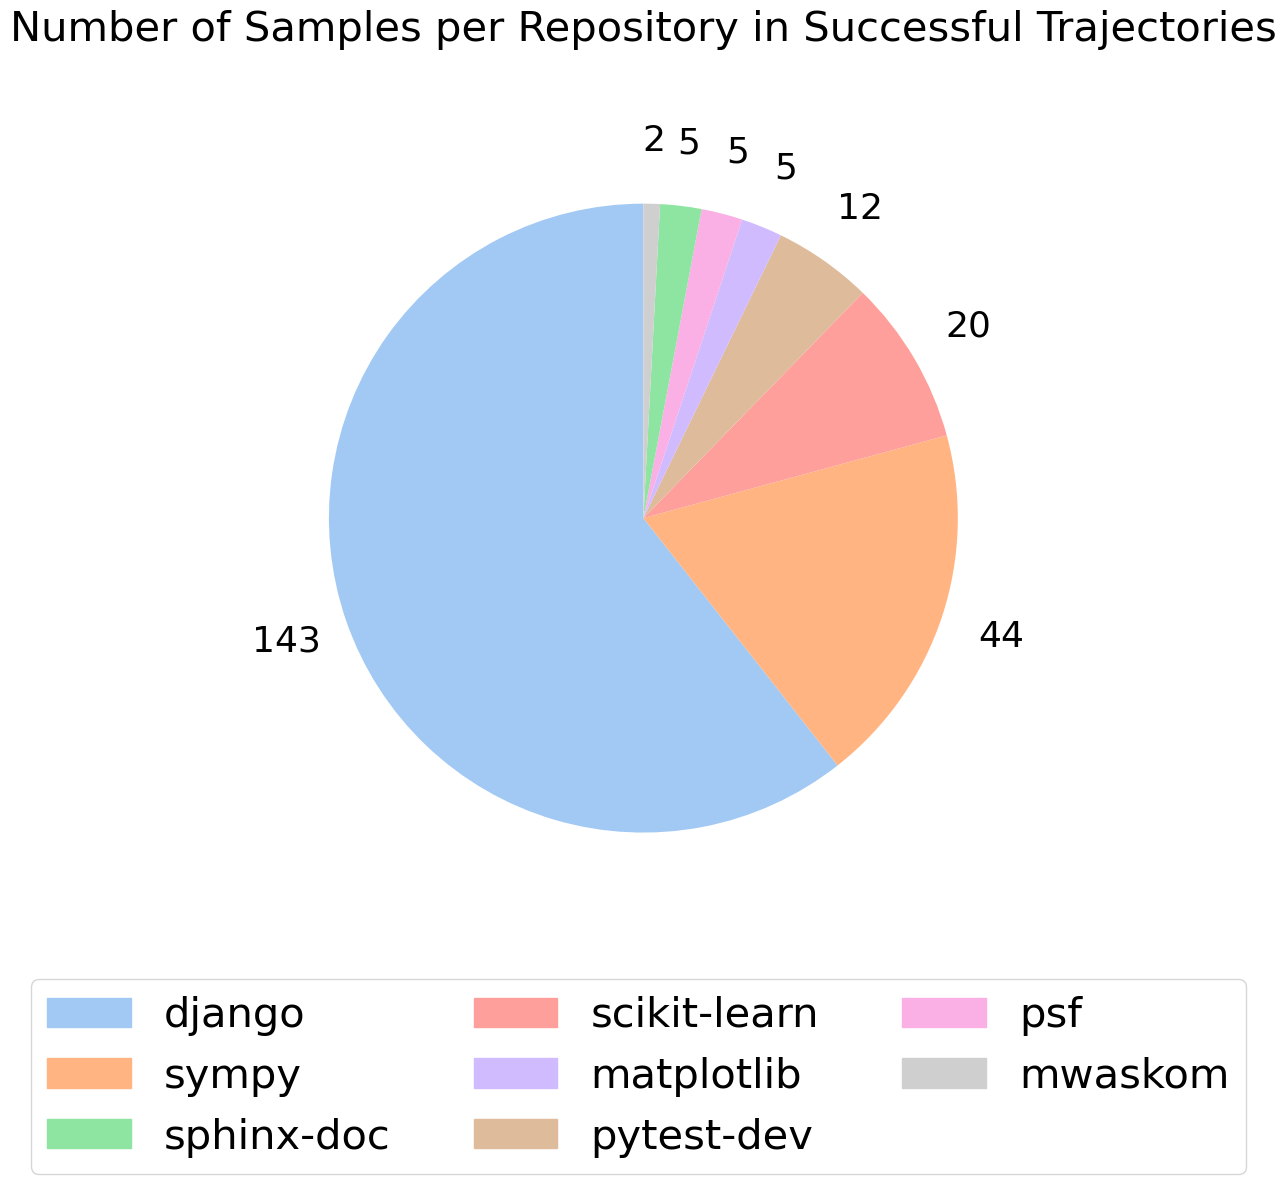

In [24]:
all_past_successful_trajectories = json.load(open('../data/all_successful_patch_trajectories.json', encoding='utf-8'))

# Convert 'instance_id' to repository names
import pandas as pd
repo_names = [item['instance_id'].split('__', 1)[0] for item in all_past_successful_trajectories]
repos = pd.Series(repo_names).value_counts()

labels1 = repos.index.tolist()
sizes1 = repos.values.tolist()

# Prepare colors for each slice in the pie chart
colors1 = [color_map.get(label, 'grey') for label in labels1]

# Create the figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 12))

# Plot the pie chart of repositories
wedges1, _ = ax.pie(sizes1, colors=colors1, startangle=90)
ax.axis('equal')
ax.set_title('Number of Samples per Repository in Successful Trajectories', fontsize=30, pad=40)

# Add annotations to the pie chart
for i, wedge in enumerate(wedges1):
    if sizes1[i] > 1:
        ang = (wedge.theta2 - wedge.theta1) / 2.0 + wedge.theta1
        x = wedge.r * 1.2 * np.cos(np.deg2rad(ang))
        y = wedge.r * 1.2 * np.sin(np.deg2rad(ang))
        ax.text(x, y, str(sizes1[i]), ha='center', va='center', fontsize=26)

# Create a legend with the repository labels in the correct order
handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i, label in enumerate(labels_train) if label in labels1]
legend_labels = [label for label in labels_train if label in labels1]
fig.legend(
    handles, legend_labels, loc='lower center', 
    ncol=(len(legend_labels) + 1) // 3, bbox_to_anchor=(0.5, -0.05), fontsize=30
)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('../report_resources/repository_distribution_successful_trajectories.pdf', bbox_inches='tight')
plt.show()

In [25]:
repos

django          143
sympy            44
scikit-learn     20
pytest-dev       12
matplotlib        5
psf               5
sphinx-doc        5
mwaskom           2
Name: count, dtype: int64

In [102]:
test_df['instance_id'].str.split('__', expand=True)[0].value_counts()

0
django          22
sympy            9
sphinx-doc       5
matplotlib       4
pytest-dev       3
mwaskom          1
scikit-learn     1
Name: count, dtype: int64

In [103]:
train_df['instance_id'].str.split('__', expand=True)[0].value_counts()

0
django          209
sympy            66
sphinx-doc       39
scikit-learn     31
matplotlib       30
pytest-dev       16
psf               8
mwaskom           1
pallets           1
Name: count, dtype: int64

# For documentation only: 
## Reshuffle until we have an more well balanced spread of empiric difficulty

In [70]:
def move(row: pd.Series, src: pd.DataFrame, dst: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Moves a specific row from one DataFrame to another.

        Parameters:
            row (pd.Series): The row to move from the source DataFrame to the destination DataFrame.
            src (pd.DataFrame): The source DataFrame from which the row will be removed.
            dst (pd.DataFrame): The destination DataFrame to which the row will be added.

        Returns:
            tuple: A tuple containing the updated source and destination DataFrames.
    """
    src.drop(row.index, inplace=True)
    dst = pd.concat([dst, row_to_shift])
    
    return src, dst

def get_minimum_deviation_stratification_class(train_df: pd.DataFrame, test_df: pd.DataFrame) -> str:
    """
    Determines which stratification class has the minimum deviation (closest to zero)
    in frequency between the training and testing datasets.

    Parameters:
        train_df (pd.DataFrame): The training dataset containing the stratification column.
        test_df (pd.DataFrame): The testing dataset containing the stratification column.

    Returns:
        The stratification class label with the minimum deviation in frequency 
        between the training and testing datasets.
    """
    stratify_column_percent_deviation = train_df.stratify_column.value_counts(normalize=True).sub(test_df.stratify_column.value_counts(normalize=True), fill_value=0)
    return stratify_column_percent_deviation.abs().idxmin()

def determine_row_to_shift_from(candidate_rows: pd.DataFrame, stratify_min_index: str) -> pd.Series:
    """
    Determines a row to shift from a given DataFrame of candidate rows.

    This function first attempts to sample a row from the candidate rows that match a specified minimum deviation class (stratify_min_index). If no rows match this criterion, it falls back to sampling a random row from the candidate rows.

    Arguments:
        candidate_rows (pd.DataFrame): The DataFrame containing candidate rows to choose from.
        stratify_min_index (str): The value used to stratify the candidate rows and select rows from the minimum deviation class.

    Returns:
        pd.Series: The row selected to be shifted from the candidate rows.
    """
    if len(candidate_rows[candidate_rows['stratify_column'] == stratify_min_index]) > 0:
        row_to_shift = candidate_rows[candidate_rows['stratify_column'] == stratify_min_index].sample(random_state=42)
    else: 
        row_to_shift = candidate_rows.sample(random_state=42)
        print(f'Unable to select candidate from minimum deviation class {stratify_min_index}, backing off to sampling a random row.')
        
    return row_to_shift

In [71]:
empiric_difficulty_percent_deviations = train_df.empiric_difficulty.value_counts(normalize=True).sub(test_df.empiric_difficulty.value_counts(normalize=True), fill_value=0) * 100

i = 0
while empiric_difficulty_percent_deviations.max() > 2 or empiric_difficulty_percent_deviations.min() < -2: 
    i += 1
    print(f'---- ITERATION {i} ----')
    max_value = empiric_difficulty_percent_deviations.max()
    max_index = empiric_difficulty_percent_deviations.idxmax()
    min_value = empiric_difficulty_percent_deviations.min()
    min_index = empiric_difficulty_percent_deviations.idxmin()
    
    print(f"Maximum value in data: {max_value} at index {max_index}")
    print(f"Minimum value in data: {min_value} at index {min_index}")
    
    stratify_min_index = get_minimum_deviation_stratification_class(train_df, test_df)
    
    # train - test 
    #   => Max class has too many elements in train
    #   => Min class has too many elements in test
    # Shift from min_index in test to train and from max_index in train to test
    candidate_rows = train_df[train_df['empiric_difficulty'] == max_index]
    row_to_shift = determine_row_to_shift_from(candidate_rows, stratify_min_index)
    train_df, test_df = move(row_to_shift, src=train_df, dst=test_df)
    print(f'Moved "{row_to_shift["instance_id"].values[0]}" with empiric difficulty "{row_to_shift["empiric_difficulty"].values[0]}" from train to test split.')
    
    stratify_min_index = get_minimum_deviation_stratification_class(train_df, test_df)
    
    candidate_rows = test_df[test_df['empiric_difficulty'] == min_index]
    row_to_shift = determine_row_to_shift_from(candidate_rows, stratify_min_index)
    test_df, train_df  = move(row_to_shift, src=test_df, dst=train_df)
    print(f'Moved "{row_to_shift["instance_id"].values[0]}" with empiric difficulty "{row_to_shift["empiric_difficulty"].values[0]}" from test to train split.\n')
    
    empiric_difficulty_percent_deviations = train_df.empiric_difficulty.value_counts(normalize=True).sub(test_df.empiric_difficulty.value_counts(normalize=True), fill_value=0) * 100

---- ITERATION 1 ----
Maximum value in data: 3.3333333333333335 at index 0.25
Minimum value in data: -6.444444444444445 at index 0.97
Unable to select candidate from minimum deviation class 1-4_hours_0.0, backing off to sampling a random row.
Moved "django__django-13670" with empiric difficulty "0.25" from train to test split.
Unable to select candidate from minimum deviation class 1-4_hours_0.0, backing off to sampling a random row.
Moved "sympy__sympy-19040" with empiric difficulty "0.97" from test to train split.

---- ITERATION 2 ----
Maximum value in data: 3.111111111111111 at index 0.61
Minimum value in data: -4.4444444444444455 at index 1.0
Unable to select candidate from minimum deviation class 1-4_hours_0.0, backing off to sampling a random row.
Moved "django__django-15380" with empiric difficulty "0.61" from train to test split.
Moved "django__django-11734" with empiric difficulty "1.0" from test to train split.

---- ITERATION 3 ----
Maximum value in data: 2.666666666666667 

FileNotFoundError: [Errno 2] No such file or directory: '.../report_resources/train_test_empiric_difficulty_deviation-after_correction.pdf'

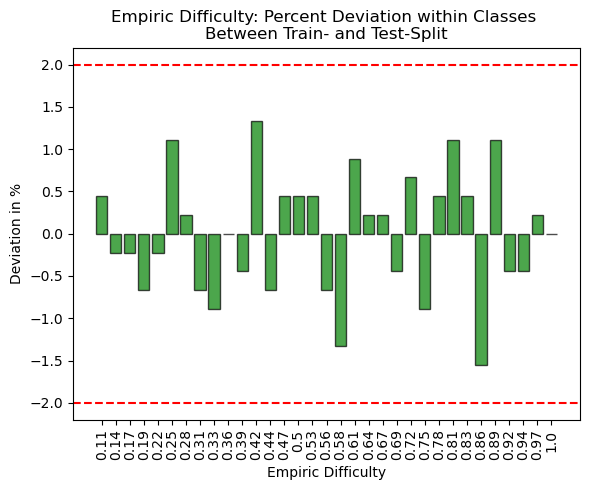

In [72]:
plt = build_empiric_difficulty_deviation_plot(train_df, test_df)
plt.savefig('.../report_resources/train_test_empiric_difficulty_deviation-after_correction.pdf')

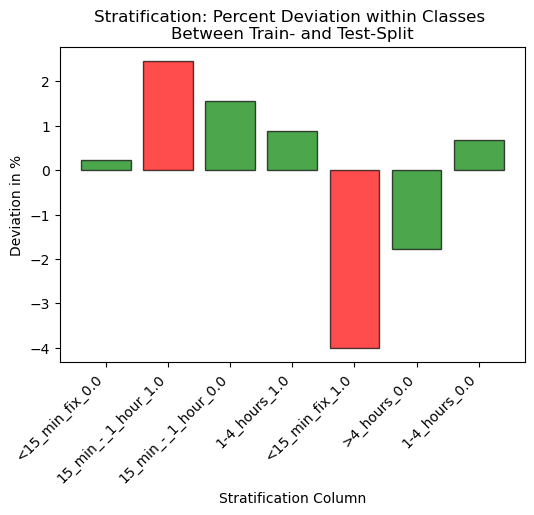

In [73]:
plt = build_stratification_class_deviation_plot(train_df, test_df)
plt.savefig('../report_resources/train_test_difficulty_deviation-after_correction.pdf')

## Hardest Setting, 90-10 split with only unresolved samples in test-split

In [74]:
test_df = swe_bench_verified[swe_bench_verified['times_solved'] == 0].sample(n=50, random_state=42)

In [75]:
train_df = swe_bench_verified.drop(test_df.index, inplace=False)

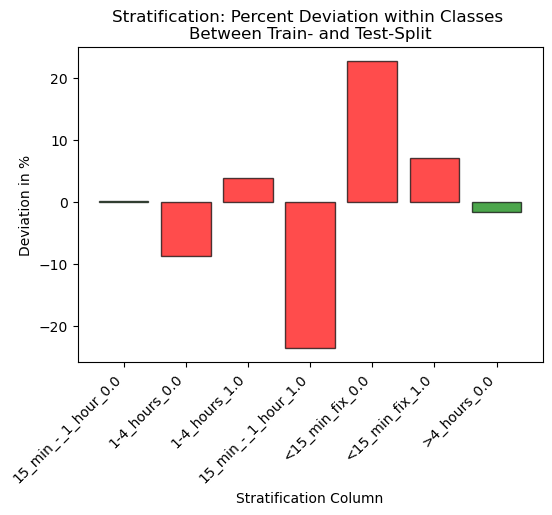

In [76]:
plt = build_stratification_class_deviation_plot(train_df, test_df)
plt.show()

We see that in this setting, in line what we have seen already above, we oversample the most difficult classes of samples: >4hrs, 1hr to 4hrs with good tests, 15min to 1hr with poor tests in the test-split. 